# Cycle-GAST

This notebook implements a Cycle-GAN based model using the GAST framework.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow_graphics.nn.loss import chamfer_distance
import time

from IPython import display

import settransformer as sf

import common

## Configuration

Select a device for training and determine the multihead attention mechanism to use for set transformers.

In [2]:
strategy = common.strategy("gpu:0")
# strategy = common.strategy(multi_gpu=True)

In [3]:
# Use either Keras MHA or the original MHA implementation as per the paper
sf.config("use_keras_mha", True)

True

## Dataset

The following cells configure the dataset

In [4]:
window = (-3, 3) # preview viewport range in plots
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

NUM_POINTS = 500 # Max set cardinality
BUFFER_SIZE = 5  # Number of buffered batches

With everything defined, we now instantiate a multiprocess data generator for paired MNIST digits. This generator only loads the digits of the supplied labels.

In [5]:
mnist_data_generator = common.MultiprocessPairedMnistGenerator(
    label_a=1,
    label_b=5,
    batch_size=GLOBAL_BATCH_SIZE,
    num_points=NUM_POINTS,
    buffer_size=BUFFER_SIZE,
    num_workers=1,
    threshold=50)

We can now start the generator to get the workers to produce new items in the dataset.

In [6]:
mnist_data_generator.start()

Let's preview a batch...

In [7]:
b = next(mnist_data_generator)

In [8]:
b[0].shape

(32, 500, 2)

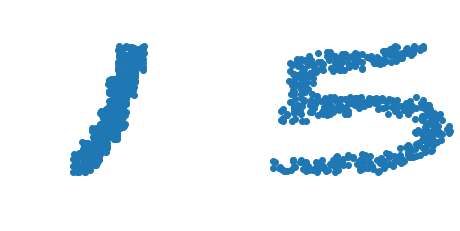

In [9]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(*b[0][0].T)
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.scatter(*b[1][0].T)
plt.xlim((-3, 3))
plt.ylim((-3, 3))
plt.axis(False)

plt.show()

Finally, we need to wrap the data generator as a Tensorflow dataset

In [10]:
train_dataset = tf.data.Dataset.from_generator(
    mnist_data_generator.generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([GLOBAL_BATCH_SIZE, NUM_POINTS, 2]),
        tf.TensorShape([GLOBAL_BATCH_SIZE, NUM_POINTS, 2])))

In [11]:
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

---

# Cycle-GAST

The following cells define the Cycle-GAST architecture for MNIST digit-to-digit mapping.

## Model Architecture

We first supply the architecture hyperparameters defining the dimensionalities of the layers and MHA mechanisms.

In [12]:
NOISE_DIM = 64
EMBED_DIM = 64
LATENT_DIM = 256
NUM_HEADS = 4
NUM_ANCHORS = 24

## Generator

In [13]:
def create_generator(name=None):
    
    # Input digit point cloud
    y = x = keras.layers.Input((None, 2))
    
    # Embed digit into permutation-invariant representation
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)
    enc = []
    for _ in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, EMBED_DIM, NUM_HEADS)(y))
    y = keras.layers.Concatenate()(enc)
    embed = y = keras.layers.Dense(LATENT_DIM)(y) # The permutation-invariant representation of the digit
    
    # Extract the set cardinality
    cardinality = keras.layers.Lambda(lambda x: tf.repeat(tf.shape(x)[1], tf.shape(x)[0]))(x)
    
    # Sample a random set
    y = common.SampleSet(NUM_POINTS, EMBED_DIM)(cardinality)

    # Condition the set
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    y = keras.layers.Add()((y1, y))
    y = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=LATENT_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, embed))
    
    # Project to spatial dimension
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(2, use_bias=False))(y)

    return keras.Model(x, y, name=name)

## Discriminator

In [26]:
def create_discriminator(name=None):
    # Input  digit point cloud
    y = x = keras.layers.Input((None, 2))
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)

    # Encode the digit
    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, LATENT_DIM, NUM_HEADS)(y))
    y = keras.layers.Concatenate()(enc)
    
    # Predict if the digit is real
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(1, use_bias=False))(y)
    
    return keras.Model(x, y, name=name)

## Model

In [27]:
with strategy.scope():
    generator_g = create_generator("X_Y")
    generator_f = create_generator("Y_X")

    discriminator_x = create_discriminator("X")
    discriminator_y = create_discriminator("Y")

In [28]:
generator_f.summary()

Model: "Y_X"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
dense_106 (Dense)               (None, None, 64)     192         input_6[0][0]                    
__________________________________________________________________________________________________
induced_set_attention_block_15  (None, None, 64)     142592      dense_106[0][0]                  
__________________________________________________________________________________________________
add_24 (Add)                    (None, None, 64)     0           dense_106[0][0]                  
                                                                 induced_set_attention_block_15[

In [29]:
discriminator_x.summary()

Model: "X"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
dense_134 (Dense)               (None, None, 64)     192         input_7[0][0]                    
__________________________________________________________________________________________________
induced_set_attention_block_18  (None, None, 64)     142592      dense_134[0][0]                  
__________________________________________________________________________________________________
add_30 (Add)                    (None, None, 64)     0           dense_134[0][0]                  
                                                                 induced_set_attention_block_18[0]

## Optimizers

In [30]:
with strategy.scope():
    gen_f_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
    gen_g_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
    
    disc_x_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)
    disc_y_optimizer = keras.optimizers.Adam(1e-4, beta_1=0.5)

## Loss Functions

Note: the original GAST paper uses a version of Hinge loss. This implementation utilizes the basic binary crossentropy loss for the generator and discriminator.

In [31]:
LAMBDA = 100

with strategy.scope():
    loss_obj = keras.losses.BinaryCrossentropy(from_logits=True, reduction="none")

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    loss = (real_loss + fake_loss) / 2.0
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(fake):
    loss = loss_obj(tf.ones_like(fake), fake)
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

def cycle_loss(real, cycled):
    loss = tf.reduce_mean(chamfer_distance.evaluate(real, cycled))
    return LAMBDA * loss

def identity_loss(real, same):
    loss = tf.reduce_mean(chamfer_distance.evaluate(real, same))
    return LAMBDA * loss

In [32]:
def lr_schedule(optimizers, decay=0.95):
    for optimizer in optimizers:
        optimizer.learning_rate.assign(optimizer.learning_rate*decay)

## Training

It's worth noting that the generator conditions currently randomly samples points regardless of the given noise input. This causes generated preview digits to be inconsistant.

In [33]:
def train_step(batch):
    
    real_x = batch[0] # 1s
    real_y = batch[1] # 5s

    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
    
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
    
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
    
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
    
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
    
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
    
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    gen_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    gen_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    disc_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    disc_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
    return total_gen_f_loss, total_gen_g_loss, disc_x_loss, disc_y_loss

@tf.function()
def distributed_train_step(batch):
    losses = strategy.run(train_step, args=(batch,))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)

In [34]:
def test(batch):
    display.clear_output(wait=True)
    
    x, y = batch
    
    fake_y = generator_g(x)
    cycled_x = generator_f(fake_y)
    same_x = generator_f(x)

    fake_x = generator_f(y)
    cycled_y = generator_g(fake_x)
    same_y = generator_g(y)
    
    plt.figure(figsize=(16, 2*6))

    for k, (real, fake, cycled, same) in enumerate([(x, fake_y, cycled_x, same_x), (y, fake_x, cycled_y, same_y)]):
        for i in range(2):
            labels = ("Real", "Fake", "Cycled", "Identity")
            digits = (real[i], fake[i], cycled[i], same[i])
            for j, (label, digit) in enumerate(zip(labels, digits)):
                plt.subplot(5, 8, 8*i + 4*k + j + 1)
                plt.title(f"{label}")
                plt.scatter(*tf.transpose(digit), s=5)
                plt.xlim((-3, 3))
                plt.ylim((-3, 3))
                plt.xticks([])
                plt.yticks([])
    plt.tight_layout()
    plt.show()

In [35]:
# Used to preview during training
test_batch = [arr.copy() for arr in next(mnist_data_generator)]
num_samples = 10
disc_losses = []
gen_losses = []
epoch = 0
num_batches = 32

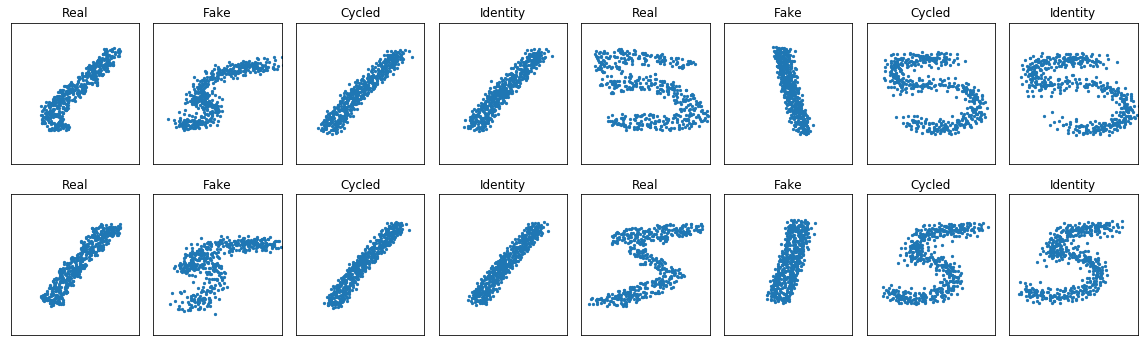

In [36]:
# Training Loop
with strategy.scope():
    
    data_iterator = iter(train_dist_dataset)
    
    for _ in range(100):

        test(test_batch)

        start = time.time()
        disc_loss = 0
        gen_loss = 0
        for i in range(num_batches):
            batch = next(data_iterator)
            losses = distributed_train_step(batch)
            disc_loss += losses[0]
            gen_loss += losses[1]
            print(f"\rEpoch: {epoch+1}; Batch: {i+1}/{num_batches}; Generator loss: {gen_loss/(i+1)}; Discriminator loss: {disc_loss/(i+1)}", end="")
        disc_losses.append(disc_loss / (i+1))
        gen_losses.append(gen_loss / (i+1))
        epoch += 1

    #     lr_schedule([gen_optimizer, disc_optimizer])

    #     if epoch % 10 == 0:
    #         model.save_weights(f"gast_epoch_{epoch}.h5")

    tf.print(f"Epoch {epoch} completed in {time.time() - start:.2f} seconds. Generator loss: {gen_losses[-1]}; Discriminator loss: {disc_losses[-1]}", end="\r")

In [38]:
generator_f.save_weights(f"./models/cyclegast_gen_f_{epoch}.h5")
generator_g.save_weights(f"./models/cyclegast_gen_g_{epoch}.h5")
discriminator_x.save_weights(f"./models/cyclegast_disc_x_{epoch}.h5")
discriminator_y.save_weights(f"./models/cyclegast_disc_y_{epoch}.h5")